In [1]:
# Normalise features
# Find the optimal parameters C (inverse regulalisation strengths)
# Find the best features to predict stock movement (up or down)
# Convert probability into absolute values (stock % increase/decrease)
# SVC, RandomForest, MinMax, LongShortTermMemory

%matplotlib inline
%pylab inline

# Nice Formatting within Jupyter Notebook
%matplotlib inline
from IPython.display import display # Allows multiple displays from a single code-cell

import os
import sys
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib
import matplotlib.pyplot as plt
import datetime
import math
import holidays

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from collections import OrderedDict
from sklearn.metrics import mean_squared_error
from alpha_vantage.timeseries import TimeSeries
from jupyterthemes import jtplot
jtplot.style(theme='grade3')



Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
class Company(object):
    def __init__(self, name):
        self.name = name
        # Create object to request data from Alpha Vantage
        self.time_series = TimeSeries(key='3OMS720IM6CRC3SV', output_format='pandas', indexing_type='date')
        data, metadata = self.time_series.get_daily_adjusted(symbol=name, outputsize='full')
        # Convert index of the DataFrame which is in the date string format into datetime
        data.index = pd.to_datetime(data.index)
        self.converted_dates = data.index # DateTimeIndex64
        self.share_prices_series = data["5. adjusted close"] # Series
        self.us_holidays = holidays.UnitedStates()
    
    def convert_date_string_to_datetime(self, date_string):
        date_day, date_month, date_year = date_string.split("/")
        return datetime.datetime(int(date_year), int(date_month), int(date_day), 0, 0)
    
    # add business days (excluding weekends only, but does not take into account HOLIDAYS as they vary country by country)
    def date_by_adding_business_days(self, from_date, add_days):
        business_days_to_add = add_days
        current_date = from_date
        while business_days_to_add > 0:
            current_date += datetime.timedelta(days=1)
            weekday = current_date.weekday()
            if weekday >= 5 or current_date in self.us_holidays: # sunday = 6
                continue
            business_days_to_add -= 1
        return current_date
    
    # Get share prices within the range
    def get_share_prices(self, start_date_string=None, end_date_string=None, start_delay=None):
        # When no date parameters are passed
        if start_date_string == None and end_date_string == None:
            return non_nan_share_prices
        else:
            # Check whether there needs "days" delay in the returned share prices
            if start_delay != None:
                start_date = self.date_by_adding_business_days(
                    from_date=self.convert_date_string_to_datetime(start_date_string), 
                    add_days=start_delay)
            else:
                start_date = self.convert_date_string_to_datetime(start_date_string)
            end_date = self.convert_date_string_to_datetime(end_date_string)
            revelant_dates = self.converted_dates[(self.converted_dates>=start_date) & (self.converted_dates<=end_date)]
            relevant_share_prices = self.share_prices_series[
                (self.share_prices_series.index>=start_date) & (self.share_prices_series.index<=end_date)]
            return relevant_share_prices
        
    # plot function for children classes, if run by parent, error would happen
    def plot(self, predictions):
        # line plot of observed vs predicted
        formatter = matplotlib.dates.DateFormatter('%d/%m/%Y')     
        
        plt.plot(predictions.index, predictions.values, ':', marker= '*', label="Predicted prices", color="blue")
        plt.plot(self.train_raw_series.index, self.train_raw_series.values,
                 '-', marker= ".", label="Actual prices (Training data)")
            
        # test data not always possible
        try:
            plt.plot(self.test_raw_series.index[:len(predictions)], 
                self.test_raw_series.values[:len(predictions)],
                 '-', marker= ".", label="Actual prices (Test data)")
        except:
            # don't plot test data if not available
            print("Exception entered")
            pass

        ax = pyplot.gcf().axes[0] 
        ax.xaxis.set_major_formatter(formatter)
        ax.legend()
        plt.gcf().autofmt_xdate(rotation=25)
        plt.gcf().set_size_inches(15, 10)
        plt.xlabel("Time")
        plt.ylabel("Share Price ($)")
        plt.title("Stock price prediction for " + self.name)
        plt.show()
        
    # score function for children classes, if run by parent, error would happen
    def score(self, metric, predictions):
        if self.test_raw_series.empty:
            raise ValueError("No test data passed so unable to score")
        elif len(self.test_raw_series) != len(predictions):
            raise ValueError("Len of test data is not equal the length of predicted data")
        
        # predictions and self.test_raw_series are series with index representing its original index in the dataset
        # root mean squared error
        if metric == "rmse":
            rmse = sqrt(mean_squared_error(self.test_raw_series, predictions))
            return rmse
        # trend whether the prediction for the next day is up or down and its accuracy
        elif metric == "trend":
            # first case is special case since the last data input from the training data is used
            price_1_day_before = self.train_raw_series[self.train_raw_series.index.tolist()[-1]]
            correct_counts = 0
            index = self.test_raw_series.index
            for i in range(1, len(self.test_raw_series)):
                if self.test_raw_series[index[i]] > price_1_day_before:
                    true_trend = "up"
                elif self.test_raw_series[index[i]] < price_1_day_before:
                    true_trend = "down"
                else:
                    true_trend = "neutral"
                
                if predictions[index[i]] > price_1_day_before:
                    predicted_trend = "up"
                elif predictions[index[i]] < price_1_day_before:
                    predicted_trend = "down"
                else:
                    predicted_trend = "neutral"
                
                if true_trend == predicted_trend:
                    correct_counts += 1
                #print("Price 1 day before", price_1_day_before)
                #print("Actual price: ", self.test_raw_series[index[i]], " | Predicted price: ", predictions[index[i]])
                #print("Actual trend: ", true_trend, " | Predicted trend: ", predicted_trend)
                # next day
                price_1_day_before = self.test_raw_series[index[i]]
            
            return correct_counts/len(self.test_raw_series)
   

In [3]:
class OneStepBaselineCompany(Company):
    def __init__(self, name, train_start_date_string, train_end_test_start_date_string, test_end_date_string):
        Company.__init__(self, name)
        self.train_raw_series = self.get_share_prices(train_start_date_string, train_end_test_start_date_string)
        self.test_raw_series = self.get_share_prices(train_end_test_start_date_string, test_end_date_string, start_delay=1)

    def train(self):
        pass

    def predict(self):
        predictions = pd.Series()
        #Persistence Model Forecast, basically, the same share price with 1 date timelag
        # e.g. the predicted share price at time t, is t-1
        if len(self.test_raw_series) > 0:
            predictions = self.test_raw_series.shift(1)
            # Special case of the first value is changed to the zero 
            predictions.at[predictions.index[0]] = self.train_raw_series.values[-1]
        else:
            # no test data inputed
            # the predicted next day price is the last price of the training data
            predictions.at[
                self.date_by_adding_business_days(
                    self.train_raw_series.index[-1], 1)] = self.train_raw_series.values[-1]
    
        return predictions
    


In [37]:
start_train_date = "01/01/2018"
end_train_start_test_date = "01/05/2018"
end_test_date = "01/10/2018"

date
2018-01-16    23.9267
2018-01-17    23.6009
2018-01-18    24.0354
2018-01-19    24.5785
2018-01-22    24.7463
2018-01-23    24.6081
2018-01-24    24.2921
2018-01-25    23.0380
2018-01-26    22.6233
2018-01-29    23.5021
2018-01-30    23.9366
2018-01-31    23.6009
2018-02-01    23.6009
Name: 5. adjusted close, dtype: float64

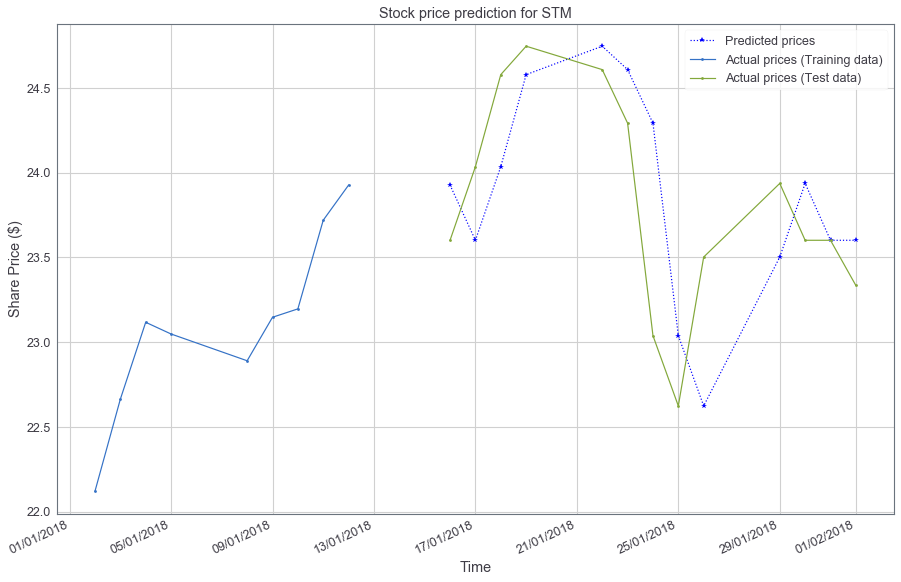

Baseline RMSE Score: 0.528 US dollar
Baseline trend Score: 7.7 %


In [5]:

company_baseline = OneStepBaselineCompany("STM", start_train_date, end_train_start_test_date, end_test_date)
company_baseline.train()
predictions = company_baseline.predict()
display(predictions)
company_baseline.plot(predictions)
rmse_score = company_baseline.score(metric="rmse", predictions=predictions)
print("Baseline RMSE Score: %.3f US dollar" % rmse_score)
trend_score = company_baseline.score(metric="trend", predictions=predictions)
print("Baseline trend Score: %.1f %%" % (trend_score*100))


In [31]:
    class OneStepLSTMCompany(Company):
        def __init__(self, name, train_start_date_string, train_end_test_start_date_string, test_end_date_string):
            Company.__init__(self, name)
            self.lstm_model = None
            self.scaler = None
            self.train_raw_series = self.get_share_prices(train_start_date_string, train_end_test_start_date_string)
            self.test_raw_series = self.get_share_prices(train_end_test_start_date_string, test_end_date_string, start_delay=1)
            self.train_scaled, self.test_scaled = self.preprocess_data()

        # create a differenced series
        def difference(self, series, source, interval=1):
            diff = list()
            # First item is special case because we use the difference of the last training pair to predict the first test price
            if source == "test":
                diff.append(self.train_raw_series.values[-1] - self.train_raw_series.values[-2])
                
            for i in range(1, len(series)):
                value = series[i] - series[i-1]
                diff.append(value)
                
            # Last item is special case because there is no next value thus the diff is 
            # 1 size shorter than the original test_raw. We fix this by adding an additional item
            if source == "test":
                diff.append(0) # placeholder for the last prediction, not used in anyway
                
            return pd.Series(diff)

        # adapted from https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
        def timeseries_to_supervised(self, data, lag=1):
            df = pd.DataFrame(data)
            columns = [df.shift(i) for i in range(1, lag+1)]
            columns.append(df)
            df = pd.concat(columns, axis=1)
            df.fillna(0, inplace=True)
            return df
        
        # invert differenced value
        def inverse_difference(self, history, yhat, interval=1):
            #print("interval", interval)
            #display(history)
            return yhat + history.values[-interval]

        # scale train and test data to [-1, 1]
        def scale(self, train, test):
            # fit scaler
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaler = scaler.fit(train)
            # transform train
            train = train.reshape(train.shape[0], train.shape[1])
            train_scaled = scaler.transform(train)
            # transform test
            test = test.reshape(test.shape[0], test.shape[1])
            test_scaled = scaler.transform(test)
            return scaler, train_scaled, test_scaled

        # inverse scaling for a forecasted value
        def invert_scale(self, X, value):
            new_row = [x for x in X] + [value]
            array = numpy.array(new_row)
            array = array.reshape(1, len(array))
            inverted = self.scaler.inverse_transform(array)
            return inverted[0, -1]

        def preprocess_data(self):
            # transform data to be stationary
            train_diff_values = self.difference(self.train_raw_series.values, "train", 1)
            test_diff_values = self.difference(self.test_raw_series.values, "test", 1)

            # transform data to be supervised learning
            train_supervised_pd = self.timeseries_to_supervised(train_diff_values, 1)
            train = train_supervised_pd.values
            
            # removes first row because it is not relevant
            test_supervised_pd = self.timeseries_to_supervised(test_diff_values, 1).iloc[1:]
            test = test_supervised_pd.values

            # transform the scale of the data
            scaler, train_scaled, test_scaled = self.scale(train, test)
            self.scaler = scaler
            
            """
            print("size of train_raw data: ", len(self.train_raw_series))
            display(self.train_raw_series)
            
            print("size of diff train data: ", len(train_diff_values))
            display(train_diff_values)
            print("size of supervised train data: ", len(train))
            display(train) 

            
            print("size of test_raw data: ", len(self.test_raw_series))
            display(self.test_raw_series)
            print("size of diff test data: ", len(test_diff_values))
            display(test_diff_values)
            print("size of supervised test data: ", len(test))
            display(test)
            """
            print("size of supervised train_scaled data: ", len(train_scaled))
            display(train_scaled)
            print("size of supervised test_scaled data: ", len(test_scaled))
            display(test_scaled)
            
            return train_scaled, test_scaled

        # fit the model
        def train(self):        
            print("Fitting the model")
            self.lstm_model = self.fit_lstm(self.train_scaled, 1, 3000, 4)
            # forecast the entire training dataset to build up state for forecasting
            train_reshaped = self.train_scaled[:, 0].reshape(len(self.train_scaled), 1, 1)
            self.lstm_model.predict(train_reshaped, batch_size=1)
            print("Finished fitting the model")

        # fit an LSTM network to training data
        def fit_lstm(self, train, batch_size, nb_epoch, neurons):
            X, y = train[:, 0:-1], train[:, -1]
            X = X.reshape(X.shape[0], 1, X.shape[1])
            model = Sequential()
            model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam')
            for i in range(nb_epoch):
                model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
                model.reset_states()
            return model

        # make a one-step forecast within test
        def forecast_lstm(self, batch_size, X):
            X = X.reshape(1, 1, len(X))
            pred = self.lstm_model.predict(X, batch_size=batch_size)
            return pred[0,0]

        # make a one-step forecast standalone
        def forecast_lstm_one_step(self, batch_size):
            predictions = pd.Series()
            unknown_next_day_price = self.scaler.transform([[0, 0]])

            print("Next day: ", unknown_next_day_price)
            X, y = unknown_next_day_price[0, 0:-1], unknown_next_day_price[0, -1]
            X = X.reshape(1, 1, len(X))
            print("X: ", X, "y: ", y)
            # predicting the change
            pred_price = self.lstm_model.predict(X, batch_size=batch_size)
            # invert scaling
            pred_price = self.invert_scale(X, pred_price)
            # invert differencing
            pred_price = pred_price + self.train_raw_series.values[-1]

            # Prediction for the next business working day
            predictions.at[self.date_by_adding_business_days(
                from_date=self.train_raw_series.index[-1], add_days=1)] = pred_price
            display(predictions)
            return predictions

        def predict(self):
            # walk-forward validation on the test data
            predictions = pd.Series()
            # Index is datetime
            test_index = self.test_raw_series.index
            #predict the fist share price after the last share price in the training data
            #pred = self.forecast_lstm(1, self.train_scaled[i, 0:-1])
            for i in range(len(self.test_scaled)):
                # make one-step forecast
                X, y = self.test_scaled[i, 0:-1], self.test_scaled[i, -1]
                print("X: ", X, "y: ", y)
                pred = self.forecast_lstm(1, X)
                # invert scaling
                pred = self.invert_scale(X, pred)
                # invert differencing
                pred = self.inverse_difference(self.test_raw_series, pred, len(self.test_scaled)-i)
                # store forecast
                predictions.at[test_index[i]] = pred

                #expected = self.invert_scale(X, y)
                #expected = self.inverse_difference(self.test_raw_series, expected, len(self.test_scaled)-i)
                #exp = self.test_raw_series[test_index[i]]
                #print('Predicted=%f, Expected Raw = %f' % (pred, exp))

            display("predictions", predictions)
            return predictions



In [38]:
stm = OneStepLSTMCompany("STM", start_train_date, end_train_start_test_date, end_test_date)
stm.train()


size of supervised train_scaled data:  82


array([[ 0.14174356,  0.57381483],
       [ 0.57381483,  0.50302259],
       [ 0.50302259,  0.08678015],
       [ 0.08678015,  0.01606745],
       [ 0.01606745,  0.34592746],
       [ 0.34592746,  0.18103723],
       [ 0.18103723,  0.55806554],
       [ 0.55806554,  0.30663379],
       [ 0.30663379, -0.11740375],
       [-0.11740375,  0.48735285],
       [ 0.48735285,  0.57373528],
       [ 0.57373528,  0.27521476],
       [ 0.27521476,  0.03181674],
       [ 0.03181674, -0.10960865],
       [-0.10960865, -0.85579065],
       [-0.85579065, -0.18811645],
       [-0.18811645,  0.84075724],
       [ 0.84075724,  0.48735285],
       [ 0.48735285, -0.1252784 ],
       [-0.1252784 ,  0.14174356],
       [ 0.14174356, -0.07039453],
       [-0.07039453, -0.48655743],
       [-0.48655743, -0.28245307],
       [-0.28245307,  0.59735921],
       [ 0.59735921, -0.4395482 ],
       [-0.4395482 , -0.9186287 ],
       [-0.9186287 ,  0.47947821],
       [ 0.47947821,  0.37742603],
       [ 0.37742603,

size of supervised test_scaled data:  106


array([[ 4.80273624e-01,  3.14985682e-01],
       [ 3.14985682e-01,  2.83487114e-01],
       [ 2.83487114e-01,  6.77139675e-01],
       [ 6.77139675e-01, -2.59783646e-01],
       [-2.59783646e-01,  4.33025772e-01],
       [ 4.33025772e-01,  4.17356029e-01],
       [ 4.17356029e-01,  2.04740694e-01],
       [ 2.04740694e-01,  3.85857461e-01],
       [ 3.85857461e-01,  6.29971365e-02],
       [ 6.29971365e-02, -2.04740694e-01],
       [-2.04740694e-01,  2.12615336e-01],
       [ 2.12615336e-01, -2.44113904e-01],
       [-2.44113904e-01,  3.85857461e-01],
       [ 3.85857461e-01,  3.14985682e-02],
       [ 3.14985682e-02, -9.44957047e-02],
       [-9.44957047e-02,  5.27601018e-01],
       [ 5.27601018e-01,  3.54358893e-01],
       [ 3.54358893e-01, -7.48011454e-01],
       [-7.48011454e-01,  7.55886096e-01],
       [ 7.55886096e-01,  2.67737830e-01],
       [ 2.67737830e-01,  5.51224944e-02],
       [ 5.51224944e-02,  1.65367483e-01],
       [ 1.65367483e-01,  9.68501432e-01],
       [ 9.

Fitting the model
Finished fitting the model


Next day:  [[0.14174356 0.14174356]]
X:  [[[0.14174356]]] y:  0.14174355711103948


2018-05-02    22.053042
dtype: float64

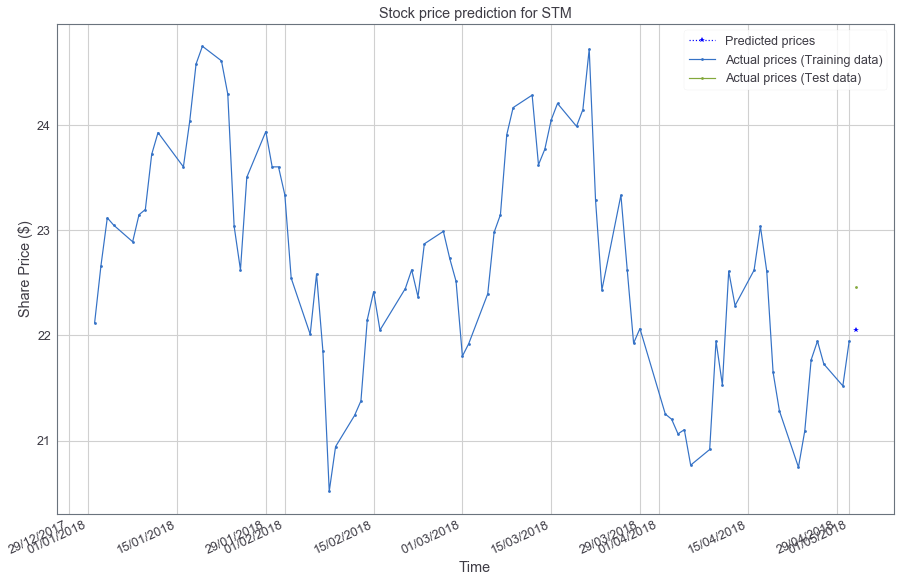

X:  [0.48027362] y:  0.31498568246897823
X:  [0.31498568] y:  0.2834871142220803
X:  [0.28348711] y:  0.6771396754692948
X:  [0.67713968] y:  -0.2597836461979009
X:  [-0.25978365] y:  0.433025771555837
X:  [0.43302577] y:  0.41735602927139515
X:  [0.41735603] y:  0.20474069360483538
X:  [0.20474069] y:  0.3858574610245
X:  [0.38585746] y:  0.0629971364937946
X:  [0.06299714] y:  -0.20474069360483804
X:  [-0.20474069] y:  0.21261533566655846
X:  [0.21261534] y:  -0.24411390391345905
X:  [-0.2441139] y:  0.3858574610245
X:  [0.38585746] y:  0.03149856824689663
X:  [0.03149857] y:  -0.09449570474069519
X:  [-0.0944957] y:  0.527601018135538
X:  [0.52760102] y:  0.35435889277759924
X:  [0.35435889] y:  -0.7480114540248164
X:  [-0.74801145] y:  0.7558860960865396
X:  [0.7558861] y:  0.2677378300986313
X:  [0.26773783] y:  0.05512249443207151
X:  [0.05512249] y:  0.16536748329621154
X:  [0.16536748] y:  0.9685014317531022
X:  [0.96850143] y:  0.5827235125676109
X:  [0.58272351] y:  -0.157492

'predictions'

2018-05-02    22.358089
2018-05-03    22.587745
2018-05-04    22.843254
2018-05-07    23.511605
2018-05-08    22.958522
2018-05-09    23.408124
2018-05-10    23.837900
2018-05-11    23.884012
2018-05-14    24.009880
2018-05-15    23.998462
2018-05-16    23.552993
2018-05-17    23.641781
2018-05-18    23.184529
2018-05-21    23.669477
2018-05-22    23.461342
2018-05-23    22.971520
2018-05-24    23.425867
2018-05-25    23.813720
2018-05-29    22.646782
2018-05-30    23.447842
2018-05-31    23.653079
2018-06-01    23.565934
2018-06-04    23.705945
2018-06-05    24.499140
2018-06-06    25.157303
2018-06-07    24.750593
2018-06-08    24.542256
2018-06-11    25.059948
2018-06-12    24.875378
2018-06-13    25.614730
                ...    
2018-08-20    19.301303
2018-08-21    19.758813
2018-08-22    19.577972
2018-08-23    19.490673
2018-08-24    20.096921
2018-08-27    20.552846
2018-08-28    20.578051
2018-08-29    20.608957
2018-08-30    20.298272
2018-08-31    20.557854
2018-09-04    19

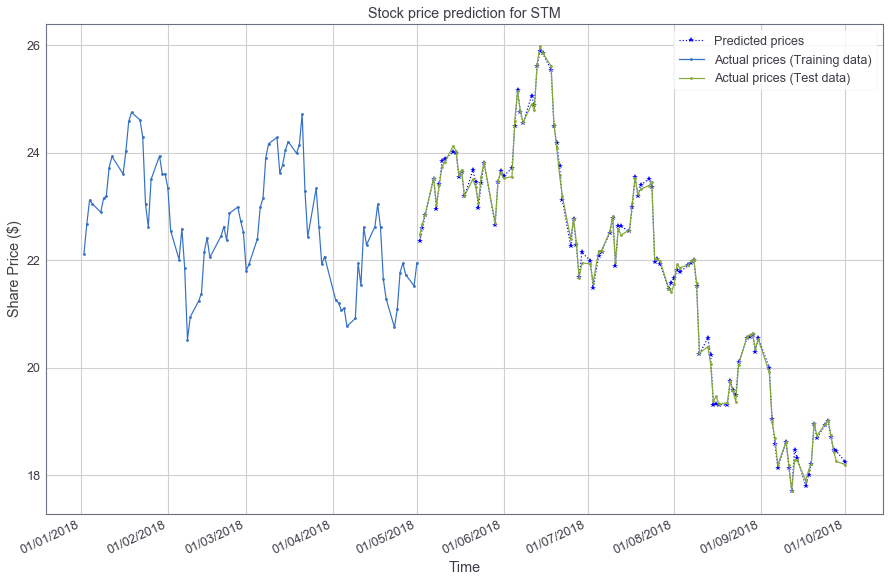

LSTM RMSE Score: 0.082 US dollar
LSTM trend Score: 88.7 %


In [39]:

one_day_pred = stm.forecast_lstm_one_step(1)
stm.plot(one_day_pred)
predictions = stm.predict()
stm.plot(predictions)

lstm_score = stm.score(metric="rmse", predictions=predictions)
print("LSTM RMSE Score: %.3f US dollar" % lstm_score)
trend_score = stm.score(metric="trend", predictions=predictions)
print("LSTM trend Score: %.1f %%" % (trend_score*100))


In [9]:
#fcau = OneStepLSTMCompany("FCAU", start_train_date, end_train_start_test_date, end_test_date)
#fcau.train()


In [10]:
#one_day_pred = fcau.forecast_lstm_one_step(1)
#fcau.plot(one_day_pred)

In [11]:
# Starts multi-step forecasting
class MultiStepBaselineCompany(Company):
    def __init__(self, name, train_start_date_string, train_end_test_start_date_string, test_end_date_string, n_lag, n_seq):
        Company.__init__(self, name)
        self.scaler = None
        self.train_raw_series = self.get_share_prices(train_start_date_string, train_end_test_start_date_string)
        self.test_raw_series = self.get_share_prices(train_end_test_start_date_string, test_end_date_string, start_delay=1)
        self.n_lag=n_lag
        self.n_seq=n_seq
        self.train, self.test = self.preprocess_data()

    # convert time series into supervised learning problem
    def series_to_supervised(self, data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    # transform series into train and test sets for supervised learning
    def preprocess_data(self):
        if self.n_seq > len(self.train_raw_series):
            raise ValueError("There are no enough training data for", self.n_seq, "sequential forecast")
        # extract raw values
        train_raw_values = self.train_raw_series.values
        train_raw_values = train_raw_values.reshape(len(train_raw_values), 1)
        # transform into supervised learning problem X, y
        supervised_train = self.series_to_supervised(train_raw_values, self.n_lag, self.n_seq)
        supervised_train_values = supervised_train.values
        
        # extract raw values
        test_raw_values = self.test_raw_series.values
        test_raw_values = test_raw_values.reshape(len(test_raw_values), 1)
        # transform into supervised learning problem X, y
        supervised_test = self.series_to_supervised(test_raw_values, self.n_lag, self.n_seq)
        supervised_test_values = supervised_test.values
        """
        print("train size: ", len(self.train_raw_series), "  train supervised size: ", len(supervised_train_values))
        display(self.train_raw_series)
        display(supervised_train_values)
        print("test size: ", len(self.test_raw_series), "  test supervised size: ", len(supervised_test_values))
        display(self.test_raw_series)
        display(supervised_test_values)
        """
        return supervised_train_values, supervised_test_values

    # make a persistence forecast
    def persistence(self, last_ob):
        return [last_ob for i in range(self.n_seq)]

    # evaluate the persistence model
    def predict(self):
        predictions = pd.Series()
        # Index is datetime
        test_index = self.test_raw_series.index

        for i in range(len(self.test)):
            X, y = self.test[i, 0:self.n_lag], self.test[i, self.n_lag:]
            #print("X: ", X, "y: ", y)
            # make forecast
            pred = self.persistence(X[-1])
            # store the forecast
            predictions.at[test_index[i]] = pred
            #predictions.append(pred)
        return predictions

    # plot function for children classes, if run by parent, error would happen
    def plot(self, predictions):
        # line plot of observed vs predicted
        formatter = matplotlib.dates.DateFormatter('%d/%m/%Y')     
        for test_date in predictions.index:
            # n_seq consecutive days
            x_axis = list()
            # The first day of test
            x_axis.append(test_date)
            for j in range(self.n_seq-1): # first one already added
                x_axis.append(self.date_by_adding_business_days(from_date=x_axis[-1], add_days=1))
            plt.plot(x_axis, predictions[test_date], ':', marker= '*', color="blue", label="Predicted prices")
        
        plt.plot(self.train_raw_series.index, self.train_raw_series.values,
                 '-', marker= ".", label="Actual prices (Training data)")
            
        # test data not always possible
        try:
            plt.plot(self.test_raw_series.index[:len(predictions)], 
                self.test_raw_series.values[:len(predictions)],
                 '-', marker= ".", label="Actual prices (Test data)")
        except:
            # don't plot test data if not available
            print("Exception entered")
            pass
        # remove repeated legends
        handles, labels = plt.gca().get_legend_handles_labels()
        i =1
        while i<len(labels):
            if labels[i] in labels[:i]:
                del(labels[i])
                del(handles[i])
            else:
                i +=1
        plt.legend(handles, labels)
        ax = pyplot.gcf().axes[0] 
        ax.xaxis.set_major_formatter(formatter)
        plt.gcf().autofmt_xdate(rotation=25)
        plt.gcf().set_size_inches(15, 10)
        plt.xlabel("Time")
        plt.ylabel("Share Price ($)")
        plt.title("Stock price prediction for " + self.name)
        plt.show()

    # evaluate the RMSE for each forecast time step
    def score(self, predictions):
        # convert predictions to an appropriate list or arrays
        predictions = np.array([lst for lst in predictions.values])
        #display("test", self.test)
        #display("predicted", predictions)
        for i in range(self.n_seq):
            # first one is the test data and the next n_seq are predictions
            actual = self.test[:,1:(self.n_lag+i+1)]
            predicted = predictions[:,:(self.n_lag+i)]
            #display("actual", actual)
            #display("predicted", predicted)
            rmse = sqrt(mean_squared_error(actual, predicted))
            print('t+%d RMSE: %f' % ((i+1), rmse))


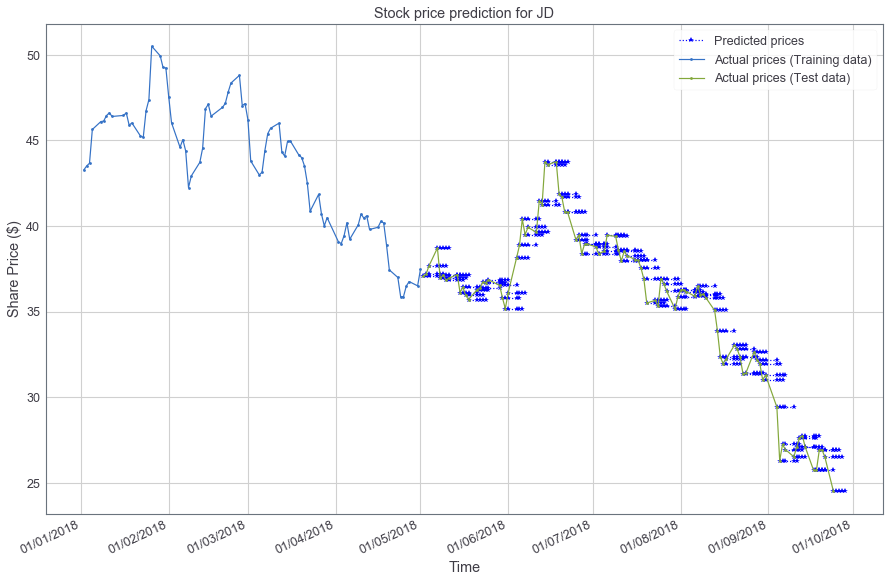

t+1 RMSE: 0.876779
t+2 RMSE: 1.094435
t+3 RMSE: 1.294963
t+4 RMSE: 1.441562
t+5 RMSE: 1.573002


In [42]:
# load dataset
start_train_date = "01/01/2018"
end_train_start_test_date = "01/05/2018"
end_test_date = "01/10/2018"

multi_step_baseline = MultiStepBaselineCompany("JD", start_train_date, end_train_start_test_date, end_test_date, 
                                               n_lag=1, n_seq=5)
predictions = multi_step_baseline.predict()
#display(predictions)
#display(multi_step_baseline.test_raw_series.values)
#display(type(multi_step_baseline.test_raw_series.values))
multi_step_baseline.plot(predictions)
multi_step_baseline.score(predictions)



In [13]:
class MultiStepLSTMCompany(Company):
    def __init__(self, name, train_start_date_string, train_end_test_start_date_string, test_end_date_string, n_lag, n_seq):
        Company.__init__(self, name)
        self.scaler = None
        self.train_raw_series = self.get_share_prices(train_start_date_string, train_end_test_start_date_string)
        self.test_raw_series = self.get_share_prices(train_end_test_start_date_string, test_end_date_string, start_delay=1)
        self.n_lag=n_lag
        self.n_seq=n_seq
        self.train, self.test = self.preprocess_data()

    # convert time series into supervised learning problem
    def series_to_supervised(self, data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    # transform series into train and test sets for supervised learning
    def preprocess_data(self):
        if self.n_seq > len(self.train_raw_series):
            raise ValueError("There are no enough training data for", self.n_seq, "sequential forecast")
        # extract raw values
        train_raw_values = self.train_raw_series.values
        train_raw_values = train_raw_values.reshape(len(train_raw_values), 1)
        # transform into supervised learning problem X, y
        supervised_train = self.series_to_supervised(train_raw_values, self.n_lag, self.n_seq)
        supervised_train_values = supervised_train.values
        
        # extract raw values
        test_raw_values = self.test_raw_series.values
        test_raw_values = test_raw_values.reshape(len(test_raw_values), 1)
        # transform into supervised learning problem X, y
        supervised_test = self.series_to_supervised(test_raw_values, self.n_lag, self.n_seq)
        supervised_test_values = supervised_test.values
        """
        print("train size: ", len(self.train_raw_series), "  train supervised size: ", len(supervised_train_values))
        display(self.train_raw_series)
        display(supervised_train_values)
        print("test size: ", len(self.test_raw_series), "  test supervised size: ", len(supervised_test_values))
        display(self.test_raw_series)
        display(supervised_test_values)
        """
        return supervised_train_values, supervised_test_values

    # make a persistence forecast
    def persistence(self, last_ob):
        return [last_ob for i in range(self.n_seq)]

    # evaluate the persistence model
    def predict(self):
        predictions = pd.Series()
        # Index is datetime
        test_index = self.test_raw_series.index

        for i in range(len(self.test)):
            X, y = self.test[i, 0:self.n_lag], self.test[i, self.n_lag:]
            #print("X: ", X, "y: ", y)
            # make forecast
            pred = self.persistence(X[-1])
            # store the forecast
            predictions.at[test_index[i]] = pred
            #predictions.append(pred)
        return predictions

    # plot function for children classes, if run by parent, error would happen
    def plot(self, predictions):
        # line plot of observed vs predicted
        formatter = matplotlib.dates.DateFormatter('%d/%m/%Y')     
        for test_date in predictions.index:
            # n_seq consecutive days
            x_axis = list()
            # The first day of test
            x_axis.append(test_date)
            for j in range(self.n_seq-1): # first one already added
                x_axis.append(self.date_by_adding_business_days(from_date=x_axis[-1], add_days=1))
            plt.plot(x_axis, predictions[test_date], ':', marker= '*', color="blue", label="Predicted prices")
        
        plt.plot(self.train_raw_series.index, self.train_raw_series.values,
                 '-', marker= ".", label="Actual prices (Training data)")
            
        # test data not always possible
        try:
            plt.plot(self.test_raw_series.index[:len(predictions)], 
                self.test_raw_series.values[:len(predictions)],
                 '-', marker= ".", label="Actual prices (Test data)")
        except:
            # don't plot test data if not available
            print("Exception entered")
            pass
        # remove repeated legends
        handles, labels = plt.gca().get_legend_handles_labels()
        i =1
        while i<len(labels):
            if labels[i] in labels[:i]:
                del(labels[i])
                del(handles[i])
            else:
                i +=1
        plt.legend(handles, labels)
        ax = pyplot.gcf().axes[0] 
        ax.xaxis.set_major_formatter(formatter)
        plt.gcf().autofmt_xdate(rotation=25)
        plt.gcf().set_size_inches(15, 10)
        plt.xlabel("Time")
        plt.ylabel("Share Price ($)")
        plt.title("Stock price prediction for " + self.name)
        plt.show()

    # evaluate the RMSE for each forecast time step
    def score(self, predictions):
        # convert predictions to an appropriate list or arrays
        predictions = np.array([lst for lst in predictions.values])
        #display("test", self.test)
        #display("predicted", predictions)
        for i in range(self.n_seq):
            # first one is the test data and the next n_seq are predictions
            actual = self.test[:,1:(self.n_lag+i+1)]
            predicted = predictions[:,:(self.n_lag+i)]
            #display("actual", actual)
            #display("predicted", predicted)
            rmse = sqrt(mean_squared_error(actual, predicted))
            print('t+%d RMSE: %f' % ((i+1), rmse))


In [ ]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test
 
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 
# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
 
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))
        
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

# load dataset
series = multi_step_baseline.train_raw_series
# configure
n_lag = 1
n_seq = 1
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)